Upload an Image...


Saving WhatsApp Image 2024-12-24 at 5.00.03 PM.jpeg to WhatsApp Image 2024-12-24 at 5.00.03 PM.jpeg
Image 'WhatsApp Image 2024-12-24 at 5.00.03 PM.jpeg' uploaded successfully!
Image loaded successfully!


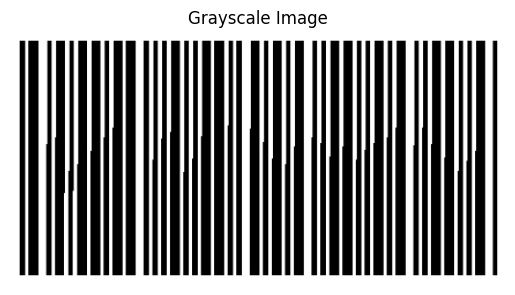

Detected Contrast Range: 255
Obstruction detected (dynamic thresholding).
Problem Detected: Obstruction
Fixing obstruction...


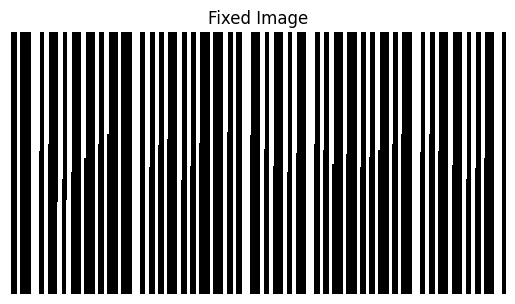

Narrow Bar Size: 6
Wide Bar Size: 12
Original Bar Lengths: [('0', 1), ('1', 6), ('0', 3), ('1', 11), ('0', 8), ('1', 5), ('0', 4), ('1', 10), ('0', 5), ('1', 4), ('0', 5), ('1', 9), ('0', 3), ('1', 11), ('0', 3), ('1', 6), ('0', 3), ('1', 11), ('0', 3), ('1', 11), ('0', 8), ('1', 5), ('0', 5), ('1', 5), ('0', 3), ('1', 6), ('0', 3), ('1', 10), ('0', 5), ('1', 5), ('0', 4), ('1', 5), ('0', 3), ('1', 11), ('0', 3), ('1', 10), ('0', 4), ('1', 6), ('0', 3), ('1', 6), ('0', 8), ('1', 10), ('0', 4), ('1', 5), ('0', 5), ('1', 9), ('0', 5), ('1', 4), ('0', 4), ('1', 10), ('0', 8), ('1', 6), ('0', 3), ('1', 6), ('0', 5), ('1', 9), ('0', 3), ('1', 11), ('0', 4), ('1', 5), ('0', 3), ('1', 6), ('0', 3), ('1', 11), ('0', 3), ('1', 6), ('0', 3), ('1', 11), ('0', 8), ('1', 5), ('0', 4), ('1', 6), ('0', 3), ('1', 10), ('0', 5), ('1', 9), ('0', 5), ('1', 4), ('0', 5), ('1', 5), ('0', 3), ('1', 10), ('0', 8), ('1', 4)]
Normalized Bar Lengths: [('0', 6), ('1', 6), ('0', 6), ('1', 12), ('0', 12), ('1', 6)

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Function to load image
def load_image():
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return None, None

    filename = next(iter(uploaded))
    print(f"Image '{filename}' uploaded successfully!")
    img = cv2.imread(filename)

    if img is None:
        print("Error: Failed to load the image. Please upload a valid image file.")
        return None, None

    return img, filename

# Function to detect if the image has low contrast
def detect_low_contrast(image, threshold=50):
    """Check if the image has low contrast based on histogram analysis."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_range = np.where(hist > 0)[0]  # Find non-zero histogram bins

    if len(hist_range) == 0:
        return False  # Empty image case
    contrast = hist_range[-1] - hist_range[0]
    print(f"Detected Contrast Range: {contrast}")
    return contrast < threshold

# Function to fix low contrast using adaptive thresholding
def fix_low_contrast(image):
    """Fix low contrast using adaptive thresholding."""
    print("Fixing low contrast...")
    img_thresholded = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 1
    )
    return img_thresholded


def detect_obstruction(image):
    # Apply Otsu's thresholding to dynamically determine the threshold value
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Check for obstructions by detecting large areas of foreground (pixels > threshold)
    # If there are large areas of white, we can assume there might be an obstruction
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True

    print("No obstruction detected.")
    return False

def fix_obstruction(image, kernel_size=(150, 1)):
    """Fix obstruction by applying adaptive thresholding and morphological operations."""
    print("Fixing obstruction...")

    # Apply Otsu's thresholding to get an optimal threshold
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological opening (erosion followed by dilation) to remove small obstructions
    kernel = np.ones(kernel_size, np.uint8)

    # Opening to remove small unwanted noise (obstruction)
    opened_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, kernel)

    # Optionally, you can apply morphological closing to fill small holes after removing obstructions
    closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel)

    return closed_image



def cropped_image(image):
    # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect vertical lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=197, maxLineGap=10)
    min_x, max_x, min_y, max_y = float('inf'), -float('inf'), float('inf'), -float('inf')

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Vertical lines: x1 == x2 or nearly vertical
            if abs(x1 - x2) < 10:
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)
            elif abs(y1 - y2) < 10:  # Horizontal lines
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)

    if min_x != float('inf') and max_x != -float('inf') and min_y != float('inf') and max_y != -float('inf'):
        return image[min_y:max_y, min_x:max_x]
    else:
      # Return the original image if no suitable lines were found for cropping
      print("Warning: No suitable lines found for cropping. Returning original image.")
      return image




def evaluate_bar(pixels, narrow_bar_size, wide_bar_size):
    # Step 1: Count consecutive pixel width

    target_pixel = pixels[0]
    bar_width = 1
    list_bar_sizes = []    #list to track each bar width

    i = 1  # Start from the second pixel
    while i < len(pixels):   #Tracks how many consecutive pixels are the same.
        if pixels[i] == target_pixel:
            bar_width += 1
        else:
            #When a consecutive pixels finishes, it saves the previous bar width
            list_bar_sizes.append((target_pixel, bar_width))

            #start tracking again
            target_pixel = pixels[i]
            bar_width = 1
        i += 1

    list_bar_sizes.append((target_pixel, bar_width))  # Append the last bar

    # Step 2: Calculate the average bar width
    #we need to determine a range of narrow and wide since it wont always be 1 or 0
    full_bar_width = 0
    for _, width in list_bar_sizes:
        full_bar_width += width
    avg_width = full_bar_width / len(list_bar_sizes)


    # Step 3: Normalize the bars based on the bar size range
    updated_bars = []
    i = 0
    while i < len(list_bar_sizes):
        pixel, width = list_bar_sizes[i]
        if width <= narrow_bar_size or width <= avg_width:
            updated_bars.append((pixel, narrow_bar_size))
        elif width > avg_width:
            updated_bars.append((pixel, wide_bar_size))
        i += 1

    # a33333 we need to turn all the bars into a string for easier representation  :)
    updated_bars_string = ""

    for pixel, width in updated_bars:
        if pixel == '1':
            updated_bars_string += '1' * width
        else:
            updated_bars_string += '0' * width

    # Debugging Output
    print("Original Bar Lengths:", list_bar_sizes)
    print("Normalized Bar Lengths:", updated_bars)
    print("Normalized Pixel String:", updated_bars_string)
    return updated_bars_string



def decode_barcode(image):
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }
    # Get the average of each column in your image
    mean = image.mean(axis=0)
    # Set it to black or white based on its value
    mean[mean <= 127] = 1
    mean[mean > 128] = 0
    # Convert to string of pixels in order to loop over it
    pixels = ''.join(mean.astype(np.uint8).astype(str))

    # Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0

    # Start counting based on whether the first pixel is "0" or "1"
    start_index = 1 if pixels[0] == "0" else 0

    # Loop through the pixels starting from the determined index
    for i in range(start_index, len(pixels)):
        if pixels[i] == "1":
            narrow_bar_size += 1
        else:
            break  # Exit the loop if a "0" is encountered after counting "1"s

    wide_bar_size = narrow_bar_size * 2



    print("Narrow Bar Size:",narrow_bar_size)
    print("Wide Bar Size:" , wide_bar_size)


    # Normalize the bar sizes
    pixels = evaluate_bar(
        pixels, narrow_bar_size, wide_bar_size)

    print("Pixels",pixels)
    print("Pixels Size:", len(pixels))

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    if pixels[0] == "0":
      skip_next = True
    else:
      skip_next = False
    while pixel_index < len(pixels):

        if skip_next:
            pixel_index += narrow_bar_size
            skip_next = False
            continue
        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except:
            pass
        pixel_index += 1
        current_digit_widths += NARROW if count == narrow_bar_size else WIDE
        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            print(current_digit_widths)
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it
    print("--------------------------------------------")
    print("Detected barcode is:")
    print("--------------------")
    print(digits)





# normal main Processing Pipeline
def process_image():
    print("Upload an Image...")

    # Step 1: Upload and load the image
    img, filename = load_image()
    if img is None:
        return

    print("Image loaded successfully!")

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Step 2: Detect the problem in the cropped image
    is_low_contrast = detect_low_contrast(img_gray)
    is_obstructed = detect_obstruction(img_gray)

    # Step 3: Choose the pipeline based on the problem
    if is_obstructed:
        print("Problem Detected: Obstruction")
        fixed_img = fix_obstruction(img_gray)
    elif is_low_contrast:
        print("Problem Detected: Low Contrast")
        fixed_img = fix_low_contrast(img_gray)
    else:
        print("No Major Problem Detected, Proceeding with Original Image")
        fixed_img = img_gray


    # Step 4: Crop the image first to focus on the barcode region
    final_img_cropped_barcode = cropped_image(fixed_img)
    #final_img_cropped_barcode2 = crop_bottom(final_img_cropped_barcode,50)



    # Step 5: Display Results
    plt.imshow(final_img_cropped_barcode, cmap='gray')
    plt.title("Fixed Image")
    plt.axis('off')
    plt.show()

    #step 6
    decode_barcode(final_img_cropped_barcode)



# Run the pipeline
process_image()

In [ ]:
!pip install pyzbar
!apt-get install libzbar0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x libfftw3-bin
  libfftw3-dev inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  libdjvulibre-text libdjvulibre21 libfftw3-doub

In [ ]:
from pyzbar import pyzbar
from pyzbar.pyzbar import decode

Upload an Image...


Saving 07 - mal7 w felfel.jpg to 07 - mal7 w felfel (1).jpg
Image '07 - mal7 w felfel (1).jpg' uploaded successfully!
Image loaded successfully!


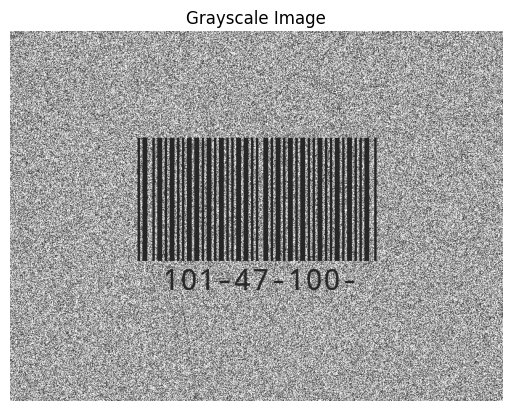

Detected Contrast Range: 236
Obstruction detected (dynamic thresholding).
Problem Detected: Obstruction
Fixing obstruction...
C [255   0   0   0   0 255 255 255 255   0   0   0   0   0   0   0   0 255
 255 255 255 255 255 255 255   0   0   0   0 255 255 255 255   0   0   0
   0   0   0   0   0 255 255 255 255   0   0   0   0 255 255 255 255   0
   0   0   0   0   0   0   0 255 255 255 255   0   0   0   0 255 255 255
 255   0   0   0   0 255 255 255 255   0   0   0   0   0   0   0   0 255
 255 255 255   0   0   0   0   0   0   0   0 255 255 255 255   0   0   0
   0 255 255 255 255   0   0   0   0   0   0   0   0 255 255 255 255   0
   0   0   0 255 255 255 255   0   0   0   0   0   0   0   0 255 255 255
 255   0   0   0   0 255 255 255 255   0   0   0   0 255 255 255 255   0
   0   0   0   0   0   0   0 255 255 255 255   0   0   0   0   0   0   0
   0 255 255 255 255   0   0   0   0 255 255 255 255   0   0   0   0 255
 255 255 255 255 255 255 255   0   0   0   0   0   0   0   0 255 255 

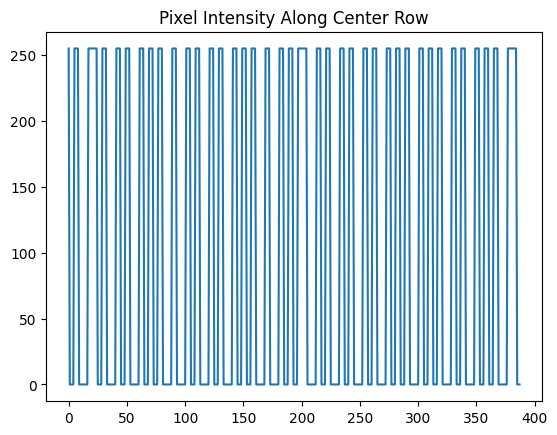

Image shape before decoding: (211, 388)


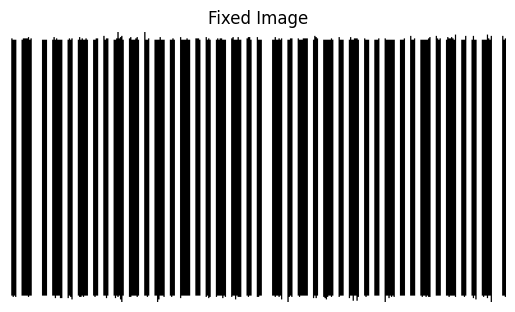

The cropped image is not None.
No barcode detected.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


# Function to load image
def load_image():
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        return None, None

    filename = next(iter(uploaded))
    print(f"Image '{filename}' uploaded successfully!")
    img = cv2.imread(filename)

    if img is None:
        print("Error: Failed to load the image. Please upload a valid image file.")
        return None, None

    return img, filename

# Function to detect if the image has low contrast
def detect_low_contrast(image, threshold=50):
    """Check if the image has low contrast based on histogram analysis."""
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_range = np.where(hist > 0)[0]  # Find non-zero histogram bins

    if len(hist_range) == 0:
        return False  # Empty image case
    contrast = hist_range[-1] - hist_range[0]
    print(f"Detected Contrast Range: {contrast}")
    return contrast < threshold

# Function to fix low contrast using adaptive thresholding
def fix_low_contrast(image):
    """Fix low contrast using adaptive thresholding."""
    print("Fixing low contrast...")
    img_thresholded = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 111, 1
    )
    return img_thresholded


def detect_obstruction(image):
    # Apply Otsu's thresholding to dynamically determine the threshold value
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Check for obstructions by detecting large areas of foreground (pixels > threshold)
    # If there are large areas of white, we can assume there might be an obstruction
    obstruction_mask = thresholded_img == 255
    if np.any(obstruction_mask):
        print("Obstruction detected (dynamic thresholding).")
        return True

    print("No obstruction detected.")
    return False

def fix_obstruction(image, kernel_size=(150, 1)):
    """Fix obstruction by applying adaptive thresholding and morphological operations."""
    print("Fixing obstruction...")

    # Apply Otsu's thresholding to get an optimal threshold
    _, thresholded_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological opening (erosion followed by dilation) to remove small obstructions
    kernel = np.ones(kernel_size, np.uint8)

    # Opening to remove small unwanted noise (obstruction)
    #opened_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_OPEN, kernel)

    # Optionally, you can apply morphological closing to fill small holes after removing obstructions
    closed_image = cv2.morphologyEx(thresholded_img, cv2.MORPH_CLOSE, kernel)

    return closed_image





def cropped_image(image):
  # Use Canny edge detection
    edges = cv2.Canny(image, 50, 150)
    # Detect vertical lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=197, maxLineGap=10)
    min_x, max_x, min_y, max_y = float('inf'), -float('inf'), float('inf'), -float('inf')

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Vertical lines: x1 == x2 or nearly vertical
            if abs(x1 - x2) < 10:
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)
            elif abs(y1 - y2) < 10:  # Horizontal lines
                min_x = min(min_x, x1, x2)
                max_x = max(max_x, x1, x2)
                min_y = min(min_y, y1, y2)
                max_y = max(max_y, y1, y2)

    if min_x != float('inf') and max_x != -float('inf') and min_y != float('inf') and max_y != -float('inf'):
        return image[min_y:max_y, min_x:max_x]

# normal main Processing Pipeline
def process_image():
    print("Upload an Image...")

    # Step 1: Upload and load the image
    img, filename = load_image()
    if img is None:
        return

    print("Image loaded successfully!")

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()

    # Step 2: Detect the problem in the cropped image
    is_low_contrast = detect_low_contrast(img_gray)
    is_obstructed = detect_obstruction(img_gray)

    # Step 3: Choose the pipeline based on the problem
    if is_obstructed:
        print("Problem Detected: Obstruction")
        fixed_img = fix_obstruction(img_gray)
    elif is_low_contrast:
        print("Problem Detected: Low Contrast")
        fixed_img = fix_low_contrast(img_gray)
    else:
        print("No Major Problem Detected, Proceeding with Original Image")
        fixed_img = img_gray


    # Step 4: Crop the image first to focus on the barcode region
    final_img_cropped_barcode = cropped_image(fixed_img)

   # Print pixel values for the center region of the cropped image
    if final_img_cropped_barcode is not None:
          center_row = final_img_cropped_barcode.shape[0] // 2
          print("C", final_img_cropped_barcode[center_row, :])
          plt.plot(final_img_cropped_barcode[center_row, :])
          plt.title("Pixel Intensity Along Center Row")
          plt.show()

   # else:
       # print("No Cropped Image Produced.")

    # Step 5: Display Results
    print(f"Image shape before decoding: {final_img_cropped_barcode.shape}")
    plt.imshow(final_img_cropped_barcode, cmap='gray')
    plt.title("Fixed Image")
    plt.axis('off')
    plt.show()

    #prepossin decoding
    #_, binarized_img = cv2.threshold(fixed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    #clean_img = cv2.morphologyEx(binarized_img, cv2.MORPH_CLOSE, kernel)
    #rotated_img = cv2.rotate(final_img_cropped_barcode, cv2.ROTATE_90_CLOCKWISE)



    # Resize the image to make the barcode larger
    resized_image = cv2.resize(final_img_cropped_barcode, (0, 0), fx=2, fy=2)  # Resize by a factor of 2

    # step 6: Decode the barcode
    # Check if the cropped image exists
    if resized_image is not None:
        barcodes = pyzbar.decode(resized_image)
        print("The cropped image is not None.")
    else:
        print("No cropped image to decode.")
        return

    if barcodes:

      for barcode in barcodes:
        x,y,w,h = barcode.rect
        cv2.rectangle(resized_image,(x,y),(x+w,y+h),0,0,255,4)
        bdata = barcode.data.decode("utf-8")
        btype = barcode.type
        text = f"{bdata}, {btype}"
        cv2.putText(resized_image,text,(x-10,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
        print(f"Detected Barcode: Data = {bdata}, Type = {btype}")
    else:
        print("No barcode detected.")


# Run the pipeline
process_image()